In [99]:
import cv2
import requests
import numpy as np
from datetime import datetime, timedelta
import os
import glob
from IPython.display import display
from PIL import Image
from matplotlib.pyplot import imshow
from pathlib import Path   
%matplotlib inline

# Params - Working directory.

In [100]:
PATH_to_stream = 'http://192.168.11.115:8080/?action=streaming'
#set Working Directory
os.chdir('/home/liteandfog/raspi-plant')
dir_path = os.path.dirname(os.path.realpath('__file__'))
Serial=str(10)
#PATH dataset -->.jpg
PATH_to_data_directory = f"/home/liteandfog/raspi-plant/d/dataset{Serial}/"
#PATH masking. 
PATH_to_masked_data_directory = f"/home/liteandfog/raspi-plant/d/dataset-m{Serial}/"

In [101]:
dir_path

'/home/liteandfog/raspi-plant'

## Set the Working directory

In [102]:
imgs_names_list =list(glob.glob(PATH_to_data_directory  + '/*'))

image name: img2021-08-10 16:55:07.944884.jpg
width: 1080 pixels
height: 720  pixels
channels: 3


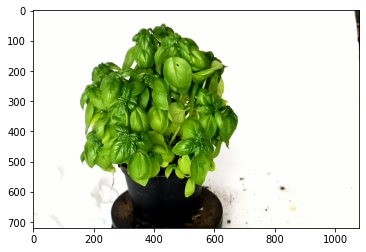

In [103]:
img_n = imgs_names_list[0] # fetch first image for testing
img_name = Path(img_n).name # fetch image name
img = cv2.imread(img_n)
(h, w, c) = img.shape[:3]
# display the image width, height, and number of channels to our
# terminal
print(f"image name: {img_name}")
print("width: {} pixels".format(w))
print("height: {}  pixels".format(h))
print("channels: {}".format(c))

imshow(np.asarray(Image.open(img_n, 'r')))

## Mask:

In [106]:
image=img.copy()
original = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([36, 0, 0], dtype="uint8")
upper = np.array([80, 250, 250], dtype="uint8")
mask = cv2.inRange(image, lower, upper)

cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cv2.fillPoly(mask, cnts, (255,255,255))
result = cv2.bitwise_and(original,original,mask=mask)

#cv2.imshow('mask', mask)
#cv2.imshow('result', result)
#cv2.waitKey()

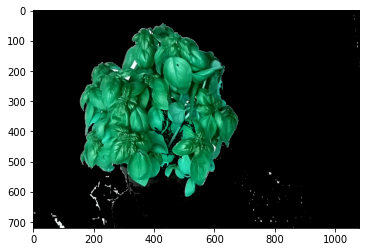

In [107]:
imshow(result)

In [108]:
im = Image.fromarray(result)
im.save("result.jpeg")

im = Image.fromarray(img)
im.save("test_img.jpeg")

## Crop

In [109]:
# Cropping an image
cropped_image = img[:,150:1000]
# Display cropped image
#cv2.imshow("cropped", cropped_image)
#cv2.waitKey()
im = Image.fromarray(cropped_image)
im.save("cropped_image.jpeg")

In [110]:
## Mask II

In [114]:
def mask_img(img_path, erode_func, output_lib = PATH_to_masked_data_directory, sbool = False, output_ext=".jpeg"):
    
    """:param img_path: string, path to the image.
       :param erode_func: function, masking function.
       :param output_lib: string, path to output directory.
       :param sbool: boolean, if True it will save the masked image, default False.  
       :param output_ext: string, type of output image, default jpeg. 
       
       :returns np.arrays of green, mask_g and img
       
       """
    
    
    img_name = os.path.splitext(Path(img_path).name)[0]
    
    #output names
    green_img_path = output_lib + '/'  + 'gr_' + img_name + output_ext #output green img path 
    mask_img_path = output_lib + '/' + 'mask_' + img_name + output_ext #output mask img path
    
    img = cv2.imread(img_path) #cv2 read and crop
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert to hsv
    mask = cv2.inRange(hsv, (36, 0, 0), (86, 255,255)) #mask by green spectrum  

    #slice out the green
    imask = mask>0
    green = np.zeros_like(img, np.uint8)
    mask_g = np.zeros_like(img, np.uint8)
    
    #make white background
    green.fill(255)

    green[imask] = img[imask]
    mask_g[~imask] = img[~ imask]
    mask_g[mask_g != 0] = 255 
    
    #crop
    green = green
    mask_g =mask_g
    img=img
    
    # erosion 
    
    
    if sbool: # save to directory if sbool == True
        cv2.imwrite(green_img_path, green)
        #cv2.imwrite(mask_img_path, mask_g)
        
    
    return erode_func(img,mask_g)

def erode_mask(img,mask_g,n=2,ite=3):
    kernel = np.ones((n,n), np.uint8)
    mask_erosion = cv2.erode(mask_g, kernel, iterations=ite)
    imask_erosion = mask_erosion == 0 
    green = np.zeros_like(img, np.uint8)
    green.fill(255)
    green[imask_erosion] = img[imask_erosion]
    return green,mask_erosion,img


In [115]:
green,mask_g,img = mask_img(img_n, erode_mask, sbool = True, output_ext=".jpg")

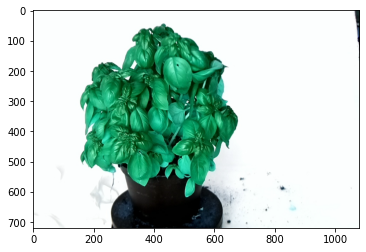

In [119]:
imshow(img)

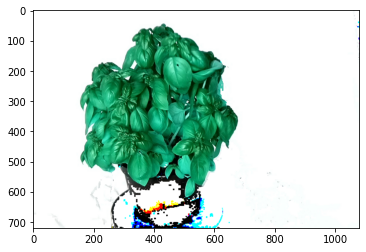

In [120]:
imshow(green)

In [30]:
green, mask_g, img = erode_mask(img, mask_g,n=2,ite=0)

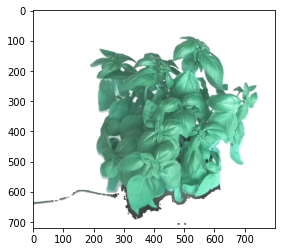

In [31]:
imshow(green)

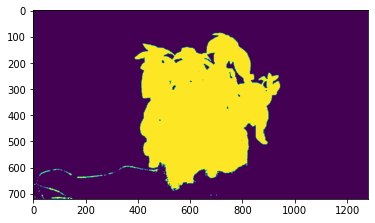

In [32]:
imshow(mask)